# Convolutional Neural Networks in Pytorch

This tutorial expects a basic understanding of pytorch and convolutional networks and focuses on pytorch-specific implementation concerns.

* `torch.nn` documentation [http://pytorch.org/docs/master/nn.html]
* Convolution animations. Make sure to understand these animations so you can visualize stride, padding, etc. [https://github.com/vdumoulin/conv_arithmetic/blob/master/README.md]
* Simple CNN model trained on MNIST: [https://github.com/cmudeeplearning11785/deep-learning-tutorials/blob/master/recitation-4/pytorch-mnist-cnn-example.py]
* If you want to look at something more complicated, check out the ResNet implementation in torchvision: [https://github.com/pytorch/vision/blob/master/torchvision/models/resnet.py]

In [1]:
import torch
import torch.nn.functional as F
from torch import autograd, nn
import numpy as np
import matplotlib.pyplot as plt
from torchvision import transforms, datasets

## Data Format

Dimension ordering is very important. For pytorch:

* 2D data like images should be `(samples, channels, height, width)` sometimes called "NCHW" or "channels first"
* 1D data like stock prices should be `(samples, channels, time)`
* 2D filters should be `(out_channels, in_channels, height, width)`
* 1D filters should be `(out_channels, in_channels, time)`

Different frameworks (e.g., TensorFlow) use different dimension orderings so be very careful, especially when implementing code or reading data targeted at a different framework.

Note most image data is RGB but some is BGR  or ARGB.

In [2]:
input_image = autograd.Variable(torch.randn(1,3,32,32)) # single 32x32 RGB image
print(input_image.size())
input_signal = autograd.Variable(torch.randn(1,40,100)) # 40 dimensional signal for 100 timesteps
print(input_signal.size())

torch.Size([1, 3, 32, 32])
torch.Size([1, 40, 100])


## Convolutional Layers

The `torch.nn` module provides layers for CNNs. Use in the same way as other modules. Please refer to the documentation for details. Some of the most common layers you will use:

* `torch.nn.Conv2d`
* `torch.nn.ConvTranspose2d`
* `torch.nn.MaxPool2d`
* `torch.nn.AvgPool2d`


In [3]:
# Create layers
layer_c2d = torch.nn.Conv2d(in_channels=3, out_channels=20, kernel_size=5, stride=1, padding=2)
layer_avg = torch.nn.AvgPool2d(kernel_size=32)

In [4]:
# Use layers directly
y = layer_c2d(input_image)
print(y.size())

torch.Size([1, 20, 32, 32])


In [5]:
# Add layers to model
model = torch.nn.Sequential(layer_avg, layer_c2d)
y = model(input_image)
print(y.size())

torch.Size([1, 20, 1, 1])


## Convolutional Functions

The `torch.nn.functional` module provides low-level functions. Depending on what kinds of models you are making, you may never have to use these functions, and use pre-made layers instead. When using the functional module, you need to instantiate parameters yourself.

http://pytorch.org/docs/0.1.12/nn.html#torch-nn-functional

Example low-level functions:

* `F.max_pool2d`
* `F.dropout2d`
* `F.conv2d`

In [6]:
filters = autograd.Variable(torch.randn(20,3,5,5)) # 5x5 filter from 3 dimensions to 20
y=F.conv2d(input_image, filters, padding=2)
print(y.size())

torch.Size([1, 20, 32, 32])


In [7]:
filters = autograd.Variable(torch.randn(256,40,5)) # 5 wide filter from 40 dimensions to 256
y=F.conv1d(input_signal, filters, padding=2)
print(y.size())

torch.Size([1, 256, 100])


For example, if you generate the kernel using a neural network, you will have to use the functional module instead of a standard convolutional layer.

## Padding

Simple 0-padding can be accomplished using the `padding` keyword argument of many functions. Normally, you will be using the same vertical and horizontal padding but you can also pass a tuple `(H,W)`. Padding is applied symmetrically.

In [8]:
inputs = autograd.Variable(torch.randn(1,3,32,32)) # single 32x32 RGB image
print(torch.nn.Conv2d(in_channels=3, out_channels=20, kernel_size=7, padding=0)(inputs).size())
print(torch.nn.Conv2d(in_channels=3, out_channels=20, kernel_size=7, padding=1)(inputs).size())
print(torch.nn.Conv2d(in_channels=3, out_channels=20, kernel_size=7, padding=2)(inputs).size())
print(torch.nn.Conv2d(in_channels=3, out_channels=20, kernel_size=7, padding=3)(inputs).size())
print(torch.nn.Conv2d(in_channels=3, out_channels=20, kernel_size=7, padding=(0,3))(inputs).size())

torch.Size([1, 20, 26, 26])
torch.Size([1, 20, 28, 28])
torch.Size([1, 20, 30, 30])
torch.Size([1, 20, 32, 32])
torch.Size([1, 20, 26, 32])


For more complicated padding, use a padding layer before your convolution.

* Single int: apply to all sides
* tuple (H,W): apply H to top and bottom, W to left and right
* tuple (left, right, top, bottom)

In [9]:
inputs = autograd.Variable(torch.randn(1,3,32,32)) # single 32x32 RGB image
y = torch.nn.Conv2d(3, 20, 7)(torch.nn.ReplicationPad2d(3)(inputs))
print(y.size())

torch.Size([1, 20, 32, 32])


Common padding layers:

* torch.nn.ReplicationPad2d
* torch.nn.ReflectionPad2d
* torch.nn.ZeroPad2d
* torch.nn.ConstantPad2d

## Normalization and Dropout

Don't forget BatchNorm2d and Dropout2d if you want to improve performance!

In [10]:
h = nn.Conv2d(3, 20, 5, padding=2)(input_image)
h = nn.BatchNorm2d(20)(h)
h = F.relu(h)
h = nn.Dropout2d(0.5)(h)
print(h.size())

torch.Size([1, 20, 32, 32])


## Downsampling

You can downsample using pooling operations or strided convolutions.

In [11]:
# Simple pooling operations
print(nn.MaxPool2d(2)(input_image).size())
print(nn.AvgPool2d(2)(input_image).size())

torch.Size([1, 3, 16, 16])
torch.Size([1, 3, 16, 16])


In [12]:
# Strided convolution
layer = torch.nn.Conv2d(in_channels=3, out_channels=20, kernel_size=5, stride=2, padding=2)
print(layer(input_image).size())

torch.Size([1, 20, 16, 16])


## Upsamping

Some operations help upsample images.

In [13]:
image_feats = autograd.Variable(torch.randn(1,20,16,16))

In [14]:
# Simple upsampling by linear or nearest neighbor
h = nn.Upsample(scale_factor=2, mode='nearest')(image_feats)
print(h.size())

torch.Size([1, 20, 32, 32])


In [15]:
# Upsample by convolution and shuffle
h = nn.Conv2d(20, 3*2*2, 5, padding=2)(image_feats)
print(h.size())
h = nn.PixelShuffle(2)(h)
print(h.size())

torch.Size([1, 12, 16, 16])
torch.Size([1, 3, 32, 32])


In [16]:
# Transposed convolution
print(input_image.size())
downsample = nn.Conv2d(3, 20, 4, stride=2, padding=2)
upsample = nn.ConvTranspose2d(20, 3, 4, stride=2, padding=2)
h = downsample(input_image)
print(h.size())
output = upsample(h)
print(output.size())

torch.Size([1, 3, 32, 32])
torch.Size([1, 20, 17, 17])
torch.Size([1, 3, 32, 32])


## Reading Image Data

For an example of reading an image dataset, see this tutorial: 
http://pytorch.org/tutorials/beginner/data_loading_tutorial.html

You can load images from image files on-the-fly or perform preprocessing and load images from numpy files or formats. Pytorch provides utilities for reading images from a folder.

**Warning** `skimage`, `Pillow` and `matplotlib` expect (H, W, channels). Make sure to transpose dimensions when going to and from pytorch.

(273, 185, 3)


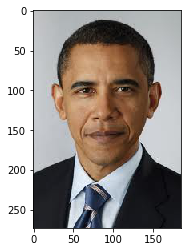

In [17]:
# Read an image using skimage
from skimage import io
image = io.imread('image_folder/face1/image1.jpg')
print(image.shape)
# Display an image
plt.imshow(image)
plt.show()

(480, 480, 3)


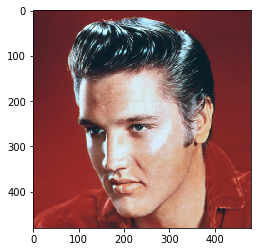

In [18]:
# Read using Pillow
from PIL import Image
image = np.array(Image.open('image_folder/face2/image2.jpg'))
print(image.shape)
plt.imshow(image)
plt.show()

(2, 3, 100, 100)
Label: 0


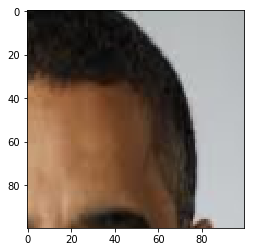

Label: 1


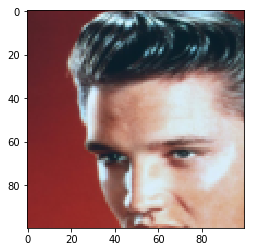

In [21]:
# Use torch ImageFolder
data_transform = transforms.Compose([
        transforms.RandomResizedCrop(100),
        transforms.RandomHorizontalFlip(),
        transforms.ToTensor()
    ])
face_dataset = datasets.ImageFolder(root='image_folder',
                                           transform=data_transform)
dataset_loader = torch.utils.data.DataLoader(face_dataset,
                                             batch_size=2,
                                             shuffle=True,
                                             num_workers=1)
for x,y in dataset_loader:
    x = x.numpy()
    print(x.shape)
    for img, label in zip(x,y):
        print("Label: {}".format(label))
        plt.imshow(img.transpose((1,2,0)))
        plt.show() 

## Masking

You may encounter unequal image sizes, attention, regions-of-interest or other situations where you need to use a mask. A mask can be used to pool over only a region of data.

* Data features (n, c, H, W) 
* Mask [0,1] (n, H, W) 

In [22]:
mask = autograd.Variable(torch.bernoulli(0.5*torch.ones(1, 32,32)))
print(mask.size())

torch.Size([1, 32, 32])


In [23]:
# Average pooling over a mask
num = (input_image*mask.unsqueeze(1)).sum(2).sum(2)  # apply mask and sum over height and width
den = mask.sum(1).sum(1).unsqueeze(1) # how many ones in the mask?
h = num / den
print(h.size())
# Alternatively, normalize the mask = attention
attn = mask / mask.sum(1).sum(1).unsqueeze(1).unsqueeze(1)
h = (input_image*attn).sum(2).sum(2)
print(h.size())

torch.Size([1, 3])
torch.Size([1, 3])


In [24]:
# Max pooling over a mask
# subtract arbitrarily large value from masked region (only for hard 0-1 masks)
h = F.max_pool2d(input_image-((1-mask)*1e6), 32) 
print(h.size())
# 0 out masked region
h = F.max_pool2d(input_image*mask.unsqueeze(1), 32)
print(h.size())

torch.Size([1, 3, 1, 1])
torch.Size([1, 3, 1, 1])
